# Fun Visualisations of the Tracked Events using `plotX`
cf. Plots when exchange for Basic Tracking (i.e. `extreme_events_basic_gridded.zarr`)

In [1]:
import xarray as xr
import numpy as np
import dask
import matplotlib.pyplot as plt
from getpass import getuser
from pathlib import Path


import marEx
import marEx.helper as hpc

In [2]:
# Directories
scratch_dir = Path('/scratch') / getuser()[0] / getuser() # Lustre Scratch Directory

file_name = scratch_dir / 'mhws' / 'extreme_events_merged_gridded.zarr'
plot_dir  = scratch_dir / 'mhws' / 'plots'

In [3]:
# Start Dask Cluster
client = hpc.start_local_cluster(n_workers=32, threads_per_worker=1,
                                 scratch_dir = scratch_dir / 'clients')  # Specify temporary scratch directory for dask to use

Dask Scratch: '/scratch/b/b382615/clients/tmpvoesdq1a'
Memory per Worker: 15.74 GB


Hostname: l40095
Forward Port: l40095:8787
Dashboard Link: localhost:8787/status


In [4]:
# Import Tracked Extremes DataSet
extreme_events_ds = xr.open_zarr(str(file_name), chunks={})
extreme_events_ds

<xarray.Dataset> Size: 40GB
Dimensions:       (ID: 9704, time: 8036, lat: 721, lon: 1440, component: 2,
                   sibling_ID: 14)
Coordinates:
  * ID            (ID) int32 39kB 1 2 3 4 5 6 ... 9699 9700 9701 9702 9703 9704
  * lat           (lat) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon           (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time          (time) datetime64[ns] 64kB 2020-01-01 ... 2041-12-31
Dimensions without coordinates: component, sibling_ID
Data variables:
    ID_field      (time, lat, lon) int32 33GB dask.array<chunksize=(25, 721, 1440), meta=np.ndarray>
    area          (time, ID) float32 312MB dask.array<chunksize=(25, 9704), meta=np.ndarray>
    centroid      (component, time, ID) float64 1GB dask.array<chunksize=(2, 25, 9704), meta=np.ndarray>
    global_ID     (time, ID) int32 312MB dask.array<chunksize=(25, 9704), meta=np.ndarray>
    merge_ledger  (time, ID, sibling_ID) int32 4GB dask.array<chunksize=(25, 9704, 14), meta=np.ndarray>
    presence      (time, ID) bool 78MB dask.array<chunksize=(25, 9704), meta=np.ndarray>
    time_end      (ID) datetime64[ns] 78kB dask.array<chunksize=(9704,), meta=np.ndarray>
    time_start    (ID) datetime64[ns] 78kB dask.array<chunksize=(9704,), meta=np.ndarray>
Attributes: (12/14)
    N_events_final:              9704
    N_objects_filtered:          103227
    N_objects_prefiltered:       206336
    R_fill:                      8
    T_fill:                      2
    accepted_area_fraction:      0.906774014002385
    ...                          ...
    area_threshold (cells):      694.0
    multi_parent_merges:         4449
    nn_partitioning:             1
    overlap_threshold:           0.5
    preprocessed_area_fraction:  0.8129384517472887
    total_merges:                19243

In [5]:
# Extract the Events ID Field
ID_field = extreme_events_ds.ID_field
ID_field

<xarray.DataArray 'ID_field' (time: 8036, lat: 721, lon: 1440)> Size: 33GB
dask.array<open_dataset-ID_field, shape=(8036, 721, 1440), dtype=int32, chunksize=(25, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 64kB 2020-01-01 2020-01-02 ... 2041-12-31

## Make a Movie using `plotX.animate`
N.B.: Making `dask`-powered movies using `animate()` cannot be threaded !

In [ ]:
# Choose a subset of the ID field
ID_field_subset = ID_field.sel(time=slice('2025-01-01', '2027-01-01'))

# Setup Plotting Configuration & Animate
config = marEx.PlotConfig(plot_IDs=True)
ID_field_subset.plotX.animate(config, plot_dir=plot_dir, file_name='movie_ID_field_gridded')

In [3]:
%%HTML
<video width="640" height="480" controls>
    <source src="../../media/movie_ID_field_gridded.mp4" type="video/mp4">
    Your browser does not support the video tag.
</video>

cf. "Basic" Tracking, i.e. the current standard method in the literature, involving _No_ temporal gap filling, _No_ merging/splitting and _No_ independent event tracking. 

In [ ]:
# Choose a subset of the "Basic" ID field
ID_field_basic_subset = xr.open_zarr(str(file_name).replace('merged', 'basic'), chunks={}).ID_field.sel(time=slice('2025-01-01', '2027-01-01'))

# Setup Plotting Configuration & Animate
config = marEx.PlotConfig(plot_IDs=True)
ID_field_basic_subset.plotX.animate(config, plot_dir=plot_dir, file_name='movie_ID_field_basic_gridded')

In [4]:
%%HTML
<video width="640" height="480" controls>
    <source src="../../media/movie_ID_field_basic_gridded.mp4" type="video/mp4">
    Your browser does not support the video tag.
</video>

## Plot Consecutive Days of Extreme Events

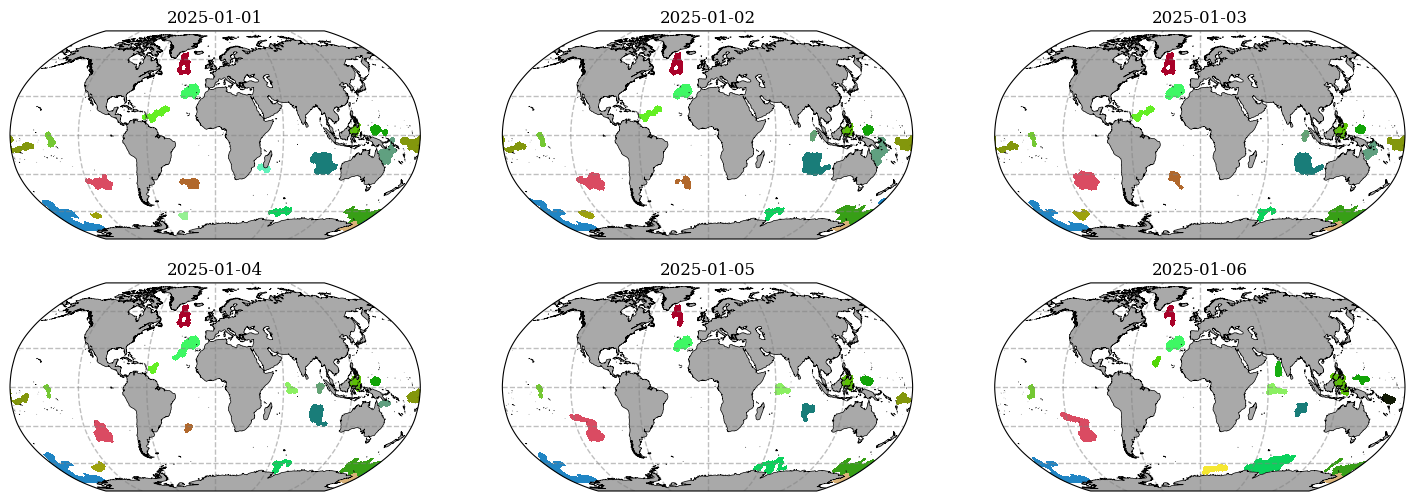

In [9]:
# Choose a subset of the ID field
ID_field_subset = ID_field.sel(time=slice('2025-01-01', '2025-01-06'))

# Setup Plotting Configuration
config = marEx.PlotConfig(plot_IDs=True)
fig, ax = ID_field_subset.plotX.multi_plot(config, col='time', col_wrap=3);

## Plot Consecutive Months of Extreme Events

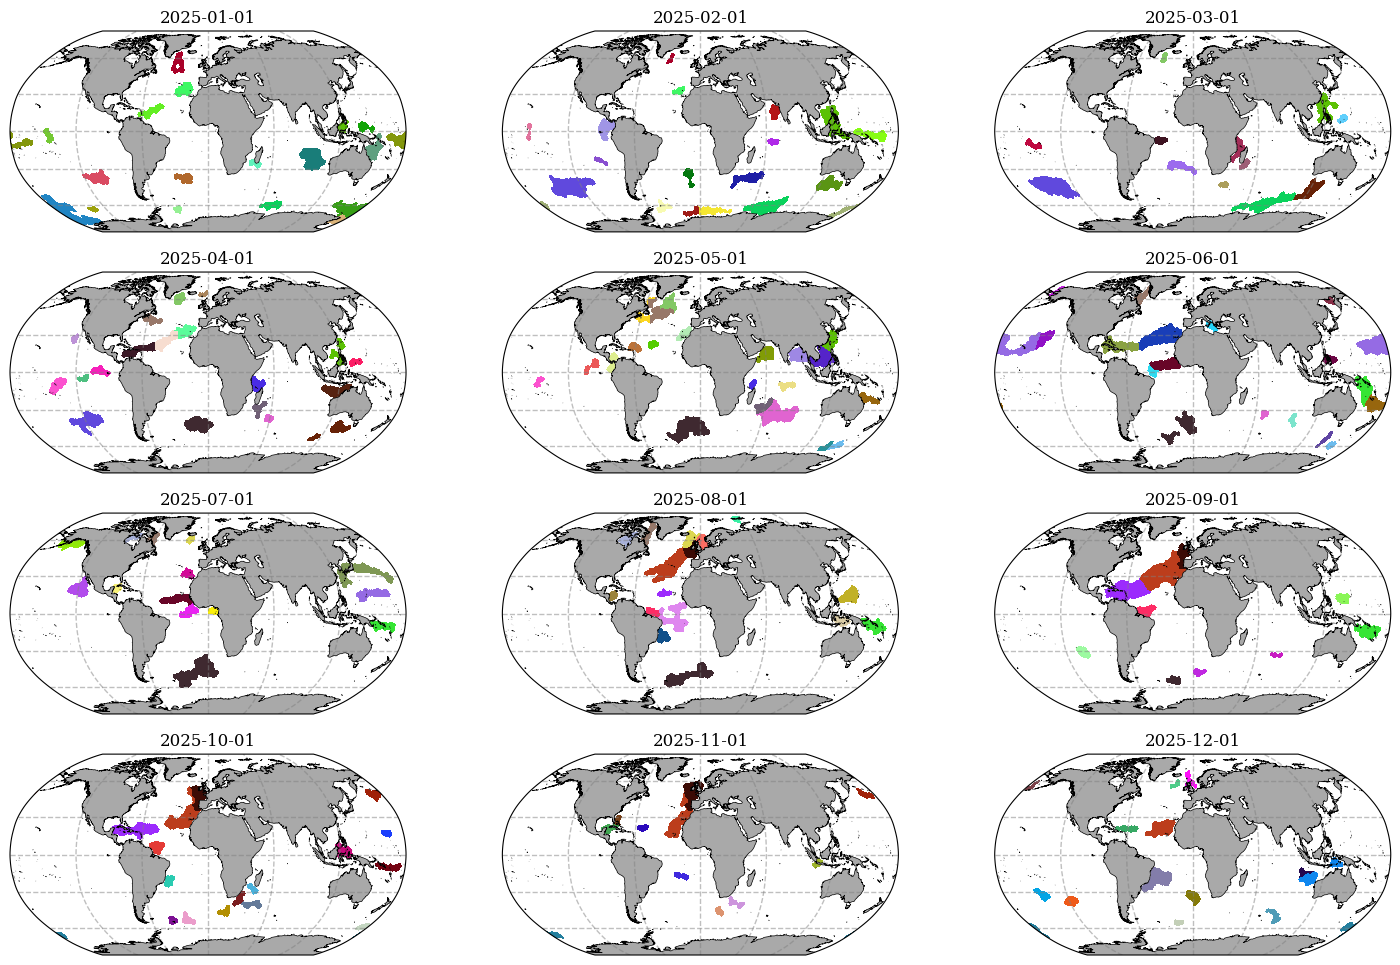

In [10]:
# Choose the first day of each month from a subset of the ID field
ID_field_subset_day1 = ID_field.sel(time=slice('2025-01-01', '2025-12-31')).resample(time='MS').first()

# Setup Plotting Configuration
config = marEx.PlotConfig(plot_IDs=True)
fig, ax = ID_field_subset_day1.plotX.multi_plot(config, col='time', col_wrap=3);


## Plot Global Extreme Event Frequency

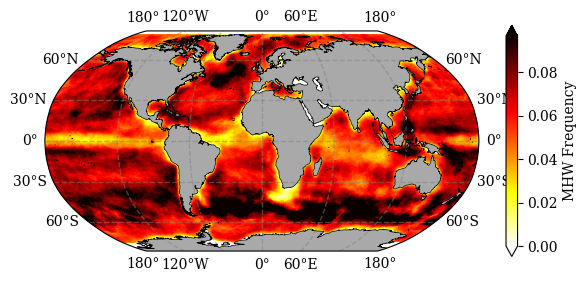

In [11]:
# Calculate the frequency of Event Occurrence
event_frequency = (ID_field > 0).mean('time')

# Setup Plotting Configuration
config = marEx.PlotConfig(var_units='MHW Frequency', cmap='hot_r', cperc=[0,96], grid_labels=True)
fig, ax = event_frequency.plotX.single_plot(config)

## Plot Seasonal Extreme Event Frequency

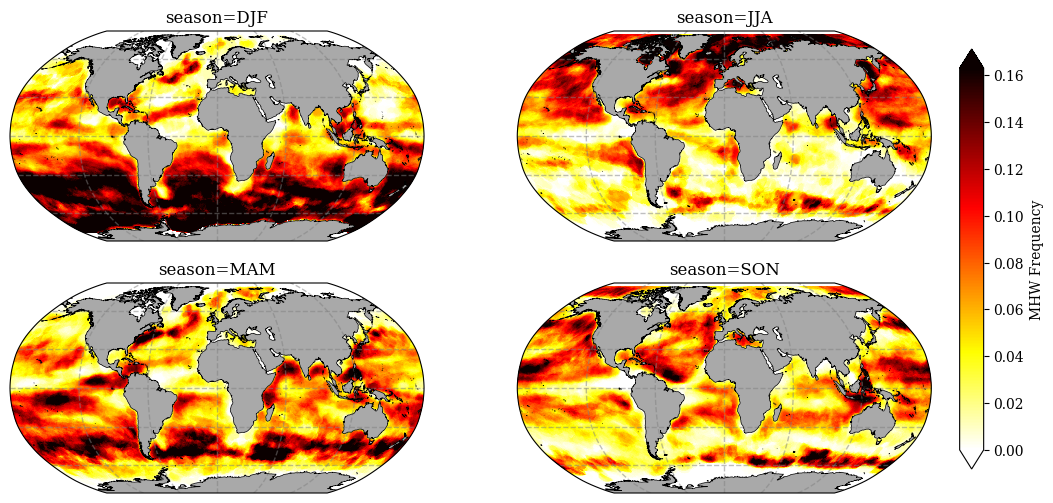

In [6]:
# Calculate the frequency of Event Occurrence per season
seasonal_frequency = (ID_field > 0).groupby('time.season').mean(dim='time')

# Setup Plotting Configuration
config = marEx.PlotConfig(var_units='MHW Frequency', cmap='hot_r', cperc=[0,96], grid_labels=True)
fig, ax = seasonal_frequency.plotX.multi_plot(config, col='season', col_wrap=2);

## Find & Plot a Few of the Longest Events

In [7]:
events_duration = extreme_events_ds.time_end - extreme_events_ds.time_start
longest_events = events_duration.sortby(events_duration, ascending=False).ID

for ID in longest_events[:10].values:
    print(f"ID: {ID:<6}   Start Day: {extreme_events_ds.time_start.sel(ID=ID).dt.strftime('%Y-%m-%d').values}  -->  Duration: {events_duration.sel(ID=ID).dt.days.values:<4} days")

ID: 1110     Start Day: 2022-07-17  -->  Duration: 381  days
ID: 3782     Start Day: 2028-06-03  -->  Duration: 339  days
ID: 3127     Start Day: 2026-12-27  -->  Duration: 307  days
ID: 1299     Start Day: 2022-12-14  -->  Duration: 273  days
ID: 7370     Start Day: 2036-11-14  -->  Duration: 269  days
ID: 9345     Start Day: 2041-04-07  -->  Duration: 268  days
ID: 7069     Start Day: 2036-02-21  -->  Duration: 264  days
ID: 5552     Start Day: 2032-06-29  -->  Duration: 251  days
ID: 999      Start Day: 2022-05-02  -->  Duration: 243  days
ID: 5532     Start Day: 2032-06-18  -->  Duration: 237  days


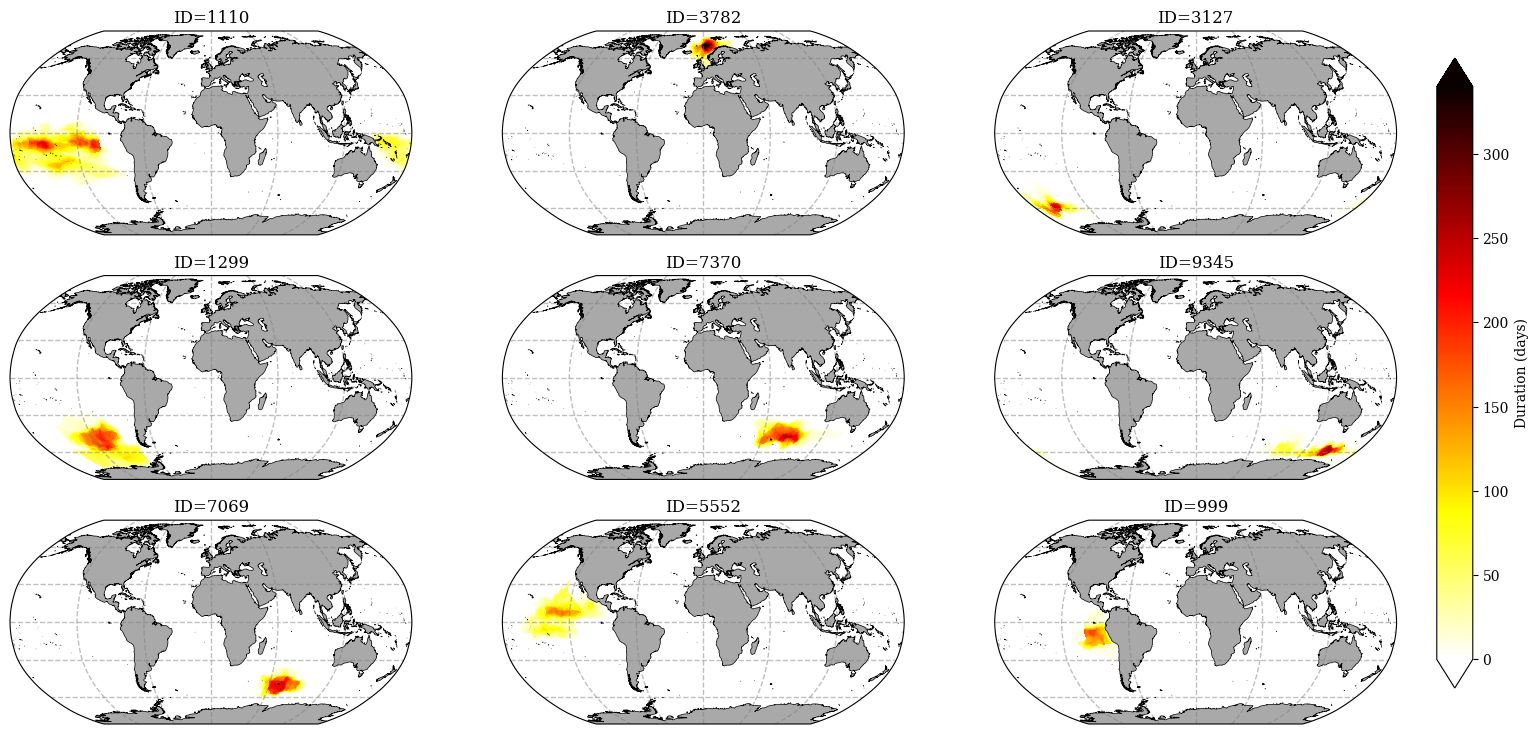

In [8]:
# Calculate the local duration of the longest events
long_events = ID_field == (longest_events[:9]).chunk({'ID':1})
long_events_local_duration = (long_events > 0).sum('time')

# Setup Plotting Configuration
config = marEx.PlotConfig(var_units='Duration (days)', cmap='hot_r', cperc=[0, 100])
fig, ax = long_events_local_duration.plotX.multi_plot(config, col='ID', col_wrap=3);

## ID Maximum and Mean Event Area
Units for `extreme_events_ds.area` when using gridded data is 'cells'. Here we must convert to km².

In [15]:
# Calculate grid areas
R_earth = 6371. #km
resolution = 0.25 #deg

lat_r, lon_r, dlat, dlon = np.radians(extreme_events_ds.lat), np.radians(extreme_events_ds.lon), np.radians(resolution), np.radians(resolution)
grid_area = (R_earth**2 * np.abs(np.sin(lat_r + dlat/2) - np.sin(lat_r - dlat/2)) * dlon).astype(np.float32)

In [ ]:
# This isn't particularly efficient, but gridded tracking has so many lat/lon grid-related biases anyways...
IDs = xr.DataArray(extreme_events_ds.ID).chunk(chunks={'ID':200})
areas = ((extreme_events_ds == IDs).sum('lon') * grid_area).sum('lat')

areas_max = areas.max().compute()
print(f'Maximum object area: {areas_max.values:.0f} km²')

areas_mean = areas.mean().compute()
print(f'Mean object area: {areas_mean.values:.0f} km²')

## Time-Series Plot of Events Area

In [ ]:
area_mean = areas.mean('ID').resample(time='ME').mean()

area_10 = areas.reduce(np.nanpercentile, q=10, dim='ID').resample(time='ME').mean()
area_90 = areas.reduce(np.nanpercentile, q=90, dim='ID').resample(time='ME').mean()

plt.figure(figsize=(15, 6))
area_mean.plot(label='Mean Area', color='k', lw=2)
plt.fill_between(area_mean.time.values, area_10, area_90, alpha=0.5)
plt.ylim([0, 8e7])
plt.ylabel(r'Event Area [km$^2$]');

## Hovmüller Plot of MHW Monthly Frequency vs Latitude

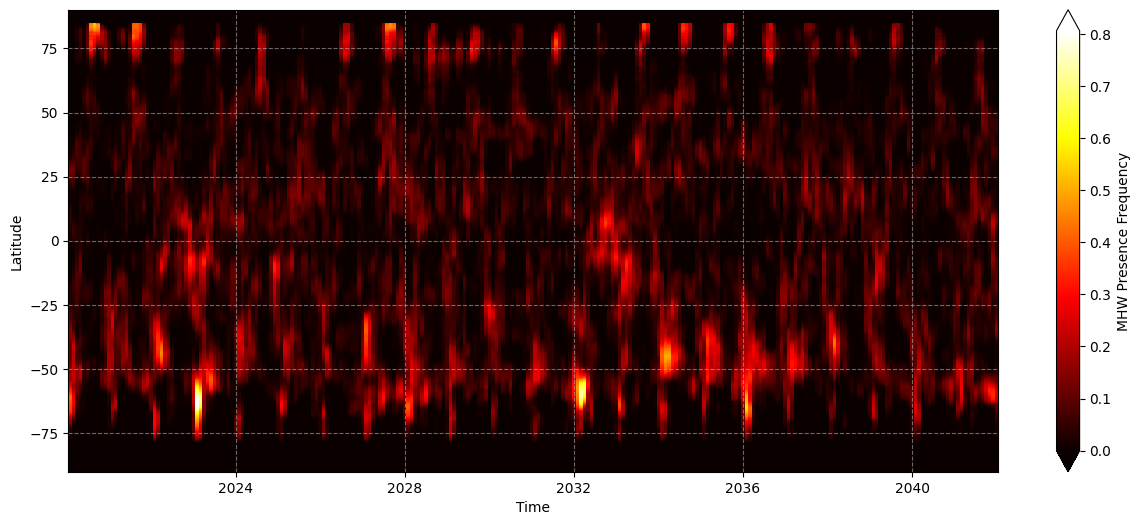

In [6]:
spatial_presence = (ID_field > 0).mean(dim='lon').resample(time='ME').mean()

fig, ax = plt.subplots(figsize=(15, 6))
im = spatial_presence.plot(ax=ax, cmap='hot', x='time',
    cbar_kwargs={
        'label': 'MHW Presence Frequency',
        'extend': 'both'})

ax.set_xlabel('Time')
ax.set_ylabel('Latitude')
ax.grid(True, linestyle='--', alpha=0.6)


## Seasonal Cycle of MHW vs Latitude

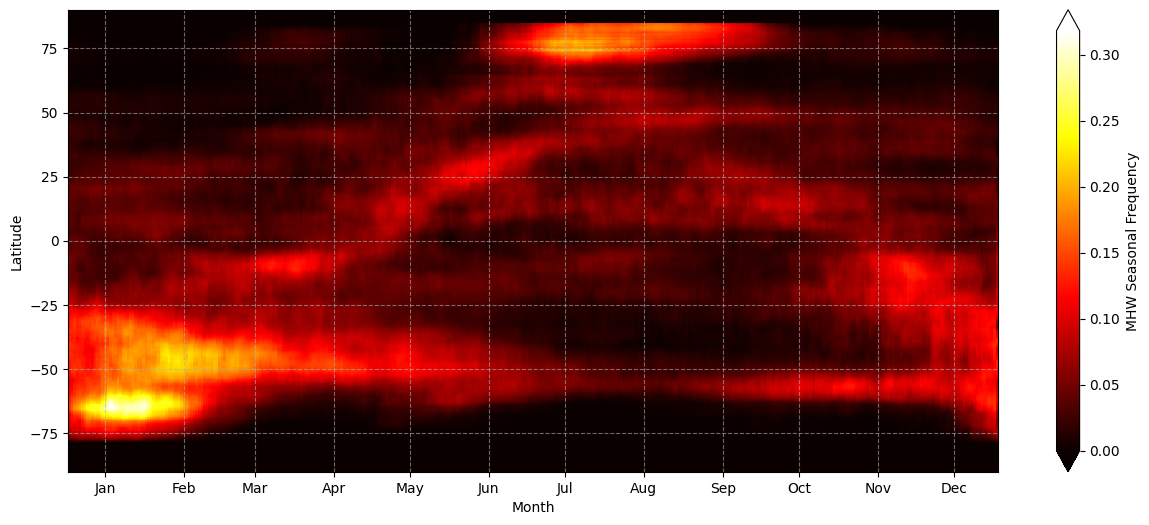

In [7]:
spatial_presence_seasonal = (ID_field > 0).mean(dim='lon').groupby('time.dayofyear').mean()

fig, ax = plt.subplots(figsize=(15, 6))
im = spatial_presence_seasonal.plot(ax=ax, cmap='hot', x='dayofyear',
    cbar_kwargs={
        'label': 'MHW Seasonal Frequency',
        'extend': 'both'})

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
month_positions = np.cumsum([0] + days_per_month[:-1]) + 15

ax.set_xticks(month_positions)
ax.set_xticklabels(months)
ax.set_xlabel('Month')
ax.set_ylabel('Latitude')
ax.grid(True, linestyle='--', alpha=0.6)
